In [15]:
import random as rd
import numpy as np
from itertools import product
from scipy import optimize
import datetime
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt



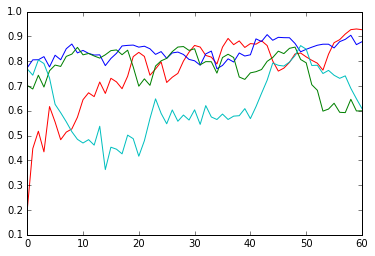

In [16]:
#Generating pairwise correlations of 10 sectors
M2_S = np.zeros((10,10))
for i,j in product (range(0,10),range(0,10)):
    if (i==j):
        M2_S[i][j] = 1.0
    else:
        if (i>j):
            M2_S[i][j] = rd.uniform(-1.0,1.0)
            M2_S[j][i] = M2_S[i][j]   


#Correlation matrix of 100 stocks based on their sector structure

def tanh(x):
    for (k,i,j) in product(range(0,61), range(0,95), range(0,95)):
        x[k][i][j] = np.tanh(x[k][i][j])


def daily_correlation(sigma):
    daily_corr = np.zeros((61, 95, 95))
    for (i, j) in product (range(0,95), range(0,95)):
        if (i>j):
            daily_corr[0][i][j] = np.random.normal(M2_S[i/10][j/10], sigma, 1)
            daily_corr[0][j][i] = daily_corr[0][i][j]
        else:
            if (i==j):
                daily_corr[0][i][j] = 1.0
        for k in range(1, 61):
            if (i>j):
                daily_corr[k][i][j] = np.random.normal(daily_corr[k-1][i][j], sigma, 1)
                daily_corr[k][j][i] = daily_corr[k][i][j]
            else:
                if (i==j):
                    daily_corr[k][i][j] = 1.0  
    tanh(daily_corr)
    return daily_corr

daily_corr = daily_correlation(0.1)


#Plots showing evolution of the correlations between some stocks
def plots(daily_corr):       
    a,b,c,d = [],[],[],[]
    for i in range (0,61):
        a.append(daily_corr[i][9][94])
        b.append(daily_corr[i][93][94])
        c.append(daily_corr[i][10][11])
        d.append(daily_corr[i][10][12])

    plt.plot(a, 'r', b, 'b', c, 'g', d, 'c')
    plt.show()

    
plots(daily_corr)

In [17]:
#Generating samples of stock returns based on their correlations over 61 days
def return_generator(N_samples, daily_corr):
    mu = np.zeros(95)
    returns = []
    for k in range(0,61):
        returns.append(np.random.multivariate_normal(mu, daily_corr[k], N_samples))
    last_returns = returns[60]
    returns = np.swapaxes(np.delete(returns, 60, axis=0), 0, 1)
    return returns, last_returns


#Empirical models for correlation matrices of stock returns constructed from 60 days
#model1 - straight-forward empirical
#model2 - with respect to the knowledge of underlying sector structure
#r1 - sample returns on the 61st day
def empiric_models(N_samples, daily_corr):
    r0, r1 = return_generator(N_samples, daily_corr)
    model1 = []
    model2 = np.zeros((N_samples, 95, 95))
    sector_average_corr = np.zeros((N_samples, 10, 10))
    for k in range(0, N_samples):
        model1.append(np.corrcoef(r0[k].transpose()))
        for (i,j) in product(range(0,9), range(0,9)):         
            if (i>j):
                sector_average_corr[k][i][j] = np.mean(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])
                sector_average_corr[k][j][i] = sector_average_corr[k][i][j]
            else:
                if (i==j):
                    sector_average_corr[k][i][j] = (np.sum(model1[k][i*10:(i+1)*10, j*10:(j+1)*10])-10)/90
        for i in range(0,9):
            sector_average_corr[k][i][9] = np.mean(model1[k][i*10:(i+1)*10, 90:95])
            sector_average_corr[k][9][i] = sector_average_corr[k][i][9]
        sector_average_corr[k][9][9] = (np.sum(model1[k][90:95, 90:95])-5)/20
        for (i,j) in product(range(0,95), range(0,95)):
            if (i==j):
                model2[k][i][j] = 1.0
            else:
                model2[k][i][j] = sector_average_corr[k][i/10][j/10]
    return model1, model2, r1
    
    
    
#Weights for standard minimum variance Markowitz portfolio
bnds = []
for i in range(0,95):
    bnds.append((0, None))
bnds = tuple(bnds)
cons_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
def portfolio_variance(x, matrix):
    p_var = np.dot(np.dot(x, matrix), x)
    return p_var
def grad_portfolio_var(x, matrix):
    grad = []
    for i in range(0,95):
        s = 2*np.dot(matrix[i], x)
        grad.append(s)
    return grad
def weights(matrix, number_of_weights):
    x0 = (1./number_of_weights)*np.ones(number_of_weights)
    res = optimize.minimize(portfolio_variance, x0, args=(matrix), method = 'SLSQP',
                            jac = grad_portfolio_var, bounds=bnds, constraints=cons_sum,
                            options={'maxiter': 100})
    return res.x


#Error function for sample/out_of_sample as variance of optimal portfolio returns
#range_of_sample - range on which we estimate optimal weights
#out_of_sample range is set to be 200
m2 = np.identity(95)
def error(x, sample_or_not, range_of_sample, m0, m1, r1):
    if (sample_or_not=='sample'):
        boundary0 = 0
        boundary1 = range_of_sample
    if (sample_or_not=='out_of_sample'):
        boundary0 = N_samples - range_of_sample
        boundary1 = N_samples
    portfolio_returns = []
    for k in range (boundary0, boundary1):
        m = x[0]*m0[k] + x[1]*m1[k] + (1-x[0]-x[1])*m2
        w = weights(m, 95)
        portfolio_returns.append(np.dot(w, r1[k]))
    return np.var(portfolio_returns)


#Optimizing model weights with positivity constraints 
#Function depending on the range_of_sample
cons = ({'type': 'ineq', 'fun': lambda x: x[0]},
       {'type': 'ineq', 'fun': lambda x: x[1]},
       {'type': 'ineq', 'fun': lambda x: 1-x[0]-x[1]})
def optimal_model_weights(a, m0, m1, r1):
    x0 = [0.5, 0.3]
    start_time = datetime.datetime.now()
    res = optimize.minimize(error, x0, args=('sample', a, m0, m1, r1), method='COBYLA',
                       constraints=cons,
                       options={'maxiter': 100})
    return datetime.datetime.now() - start_time, res.x, res.fun




In [18]:
sigma_values = np.sort(np.random.uniform(0.05, 0.3, 100))
I = [20., 27., 34., 40., 46., 52., 59., 66., 73., 79.]
def stump(sigma_values, samples_per_stump):
    times, results, sample_errors = [], [], []
    daily_corr = daily_correlation(sigma_values[0])
    m0_all, m1_all, r1_all = empiric_models(samples_per_stump, daily_corr)
    for i in range(1,100):
        daily_corr = daily_correlation(sigma_values[i])
        m0_upd, m1_upd, r1_upd = empiric_models(samples_per_stump, daily_corr)
        m0_all = np.concatenate((m0_all, m0_upd), 0)
        m1_all = np.concatenate((m1_all, m1_upd), 0)
        r1_all = np.concatenate((r1_all, r1_upd), 0)
    for i in range(0,20): 
        bnd1, bnd2 = 20*(i+1), samples_per_stump*100
        m0, m1, r1 = m0_all[bnd1:bnd2], m1_all[bnd1:bnd2], r1_all[bnd1:bnd2]
        time, result, value = optimal_model_weights(len(m0), m0, m1, r1)
        print result
        result = [[0., 0.], result]
        times.append(time)
        results.append(result)
        sample_errors.append(value)
    for i in range(20, 80):
        bnd1, bnd2 = 20*(i+1), samples_per_stump*100
        m0, m1, r1 = m0_all[0:bnd1], m1_all[0:bnd1], r1_all[0:bnd1]
        time1, result1, value1 = optimal_model_weights(len(m0), m0, m1, r1)
        m0, m1, r1 = m0_all[bnd1:bnd2], m1_all[bnd1:bnd2], r1_all[bnd1:bnd2]
        time2, result2, value2 = optimal_model_weights(len(m0), m0, m1, r1)
        result = [result1, result2]
        print result
        times.append(time1), times.append(time2)
        results.append(result)
        sample_errors.append(value1), sample_errors.append(value2)
    for i in range(80,100):
        bnd1, bnd2 = 0, 20*(i+1)
        m0, m1, r1 = m0_all[bnd1:bnd2], m1_all[bnd1:bnd2], r1_all[bnd1:bnd2]
        time, result, value = optimal_model_weights(len(m0), m0, m1, r1)
        print result
        result = [result, [0., 0.]]
        times.append(time)
        results.append(result)
        sample_errors.append(value)
    return times, results, sample_errors
        

In [ ]:
t, r, s_e = stump(sigma_values, 10)
print t
print s_e
print r